In [2]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
from torchvision.models import resnet50,ResNet50_Weights
import shap
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### To explain shap values for a custom image

In [3]:
def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define the transformations (here we are using the ImageNet transformations)

def transform_img(img,transform_flag = 'Y'):
    transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
    arr_img = np.array(img)
    # apply the transforms
    trans_img = transform(arr_img)
    # unsqueeze to add a batch dimension
    trans_img = trans_img.unsqueeze(0)
    if transform_flag == 'N':
        trans_img = np.array(trans_img)
        trans_img = trans_img.swapaxes(-1,1)
        return trans_img
    else:
        return trans_img

# read and visualize the image
path_to_img = 'images/dog.jpg'
img = read_img(path_to_img)

In [4]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


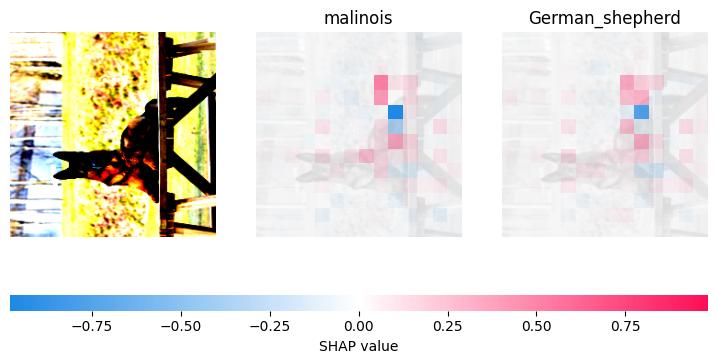

In [6]:
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

X,y = shap.datasets.imagenet50()
X /= 255

to_explain = transform_img(img)

e = shap.GradientExplainer((model, model.layer4), normalize(X))
shap_values,indexes = e.shap_values(to_explain,ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

to_plot_explain = transform_img(img,"N")
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_plot_explain, index_names)

### To explain shap values for image in image net dataset

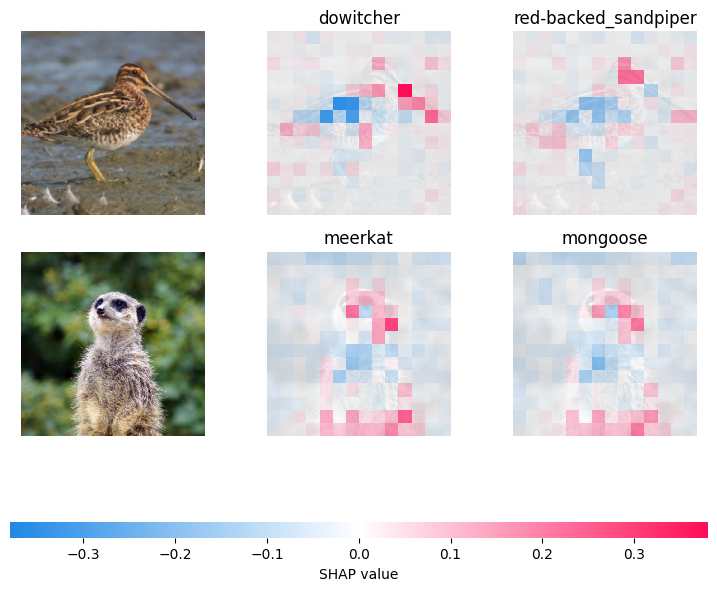

In [7]:
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

X,y = shap.datasets.imagenet50()
X /= 255

to_explain = X[[39,41]]

e = shap.GradientExplainer((model, model.layer4), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain),ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)